## Importing Required Libraries

This section imports all necessary Python libraries used throughout the machine learning pipeline.

- **NumPy & Pandas** are used for numerical operations and data manipulation.
- **Scikit-learn** provides tools for preprocessing, model training, evaluation, and cross-validation.
- **Matplotlib** is used for visualizing model performance.

All libraries are standard in data science workflows and ensure reproducibility of the analysis.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Data Loading and Initial Cleaning

In this step, the traditional advertising dataset and the digital marketing dataset are loaded separately.

Basic cleaning operations are applied:
- Irrelevant index columns are removed.
- Rows with missing values are dropped.
- Monetary values in the digital dataset are converted from string format (e.g., "$12,345") to numeric values.

This ensures that both datasets are analysis-ready and suitable for feature engineering and modeling.


In [2]:
adv = pd.read_csv("advertising.csv")
dig = pd.read_csv("digital_marketing.csv")

# Advertising clean
adv = adv.drop(columns=[c for c in ["Unnamed: 0"] if c in adv.columns])
adv = adv.dropna().reset_index(drop=True)

# Digital clean
dig = dig.dropna().reset_index(drop=True)

# Acquisition_Cost: "$16,174.00" -> 16174.00
dig["Acquisition_Cost"] = (
    dig["Acquisition_Cost"].astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .astype(float)
)

print("Advertising shape:", adv.shape)
print("Digital shape    :", dig.shape)
print("Advertising columns:", adv.columns.tolist())
print("Digital columns    :", dig.columns.tolist())


Advertising shape: (200, 4)
Digital shape    : (200000, 16)
Advertising columns: ['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)', 'Sales ($)']
Digital columns    : ['Campaign_ID', 'Company', 'Campaign_Type', 'Target_Audience', 'Duration', 'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost', 'ROI', 'Location', 'Language', 'Clicks', 'Impressions', 'Engagement_Score', 'Customer_Segment', 'Date']


## Digital Feature Engineering

The raw digital marketing data does not directly contain all variables required for analysis.
Therefore, several meaningful features are engineered:

- **Click-Through Rate (CTR):** Measures engagement efficiency as Clicks / Impressions.
- **Conversions:** Approximated using Clicks × Conversion_Rate.
- **Digital_Spend:** Derived from acquisition cost and rescaled to thousands of dollars
  to ensure comparability with traditional advertising budgets.

These engineered features allow digital marketing performance to be analyzed alongside traditional media.


In [3]:
# CTR
dig["CTR"] = dig["Clicks"] / dig["Impressions"].replace(0, np.nan)
dig["CTR"] = dig["CTR"].fillna(0)

# Conversions (approx.)
dig["Conversions"] = dig["Clicks"] * dig["Conversion_Rate"]

# Digital_Spend (thousands of dollars)
dig["Digital_Spend"] = dig["Acquisition_Cost"] / 1000.0

dig_ml = dig[["Digital_Spend", "CTR", "Conversions", "ROI", "Engagement_Score"]].copy()
dig_ml.describe().T


,count,mean,std,min,25%,50%,75%,max
Digital_Spend,200000.0,12.504393,4.337665,5.000000,8.739750,12.496500,16.264000,20.000000
CTR,200000.0,0.140405,0.130881,0.010054,0.058606,0.099789,0.169699,0.992024
Conversions,200000.0,44.022898,32.317026,1.000000,17.760000,35.760000,64.100000,150.000000
ROI,200000.0,5.002438,1.734488,2.000000,3.500000,5.010000,6.510000,8.000000
Engagement_Score,200000.0,5.494710,2.872581,1.000000,3.000000,5.000000,8.000000,10.000000


## Dataset Alignment and Combination

The traditional and digital datasets do not share a common campaign or time identifier.
To enable joint modeling, an index-based alignment strategy is applied:

- A subset of digital campaigns is randomly sampled to match the size of the advertising dataset.
- The two datasets are then concatenated by index.

This approach allows exploratory modeling of cross-channel effects while acknowledging that
the alignment is synthetic rather than a real-world campaign match.


In [4]:
# Making digital side same length as advertising by sampling
n = len(adv)
dig_sample = dig_ml.sample(n=n, random_state=42).reset_index(drop=True)

# Combining by index alignment
df = pd.concat([adv.reset_index(drop=True), dig_sample], axis=1)

print("Merged df shape:", df.shape)
df.head()


Merged df shape: (200, 9)


,TV Ad Budget ($),Radio Ad Budget ($),Newspaper Ad Budget ($),Sales ($),Digital_Spend,CTR,Conversions,ROI,Engagement_Score
0,230.1,37.8,69.2,22.1,7.089,0.085517,55.36,6.34,2
1,44.5,39.3,45.1,10.4,13.500,0.030482,8.07,2.75,4
2,17.2,45.9,69.3,9.3,9.687,0.092941,58.80,3.72,5
3,151.5,41.3,58.5,18.5,8.760,0.186497,55.44,5.45,7
4,180.8,10.8,58.4,12.9,18.925,0.073058,59.18,6.72,1


## Cross-Channel Synergy Feature

To test whether traditional and digital channels reinforce each other,
an interaction term between TV advertising and Digital_Spend is created.

This interaction captures **non-additive effects**, where the combined influence
of TV and digital advertising may exceed their individual contributions.

The interaction term directly operationalizes the cross-channel synergy hypothesis (H3).


In [5]:
tv_col = "TV Ad Budget ($)"
target_col = "Sales ($)"

# Safety checks
for c in [tv_col, "Radio Ad Budget ($)", "Newspaper Ad Budget ($)", target_col, "Digital_Spend", "CTR", "Conversions"]:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

df["TV_x_Digital"] = df[tv_col] * df["Digital_Spend"]
df[["TV_x_Digital"]].head()


,TV_x_Digital
0,1631.1789
1,600.7500
2,166.6164
3,1327.1400
4,3421.6400


## Defining Features and Target Variable

In this step, the modeling variables are defined:

- **X (features):** Includes traditional media budgets, digital engagement variables,
  and the interaction term.
- **y (target):** Sales revenue.

Separating features and the target variable clarifies the prediction task
and prepares the data for machine learning models.


In [6]:
features = [
    "TV Ad Budget ($)",
    "Radio Ad Budget ($)",
    "Newspaper Ad Budget ($)",
    "Digital_Spend",
    "CTR",
    "Conversions",
    "ROI",
    "Engagement_Score",
    "TV_x_Digital"
]
target = "Sales ($)"

X = df[features].copy()
y = df[target].copy()


## Train–Test Split

The dataset is split into training and testing subsets.

- **Training set:** Used to fit the models.
- **Test set:** Held out for evaluating generalization performance.

This separation ensures that model evaluation reflects performance on unseen data,
which is critical for assessing predictive validity.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)


(160, 9) (40, 9)


## Preprocessing and Model Pipelines

Before training, numerical features are standardized using a scaler.
Standardization is important because features are measured on different scales
(e.g., budgets vs engagement rates).

Pipelines are constructed to:
- Apply preprocessing consistently
- Prevent data leakage
- Combine preprocessing and modeling into a single, reproducible workflow

Three models are prepared:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor


In [8]:
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), features)],
    remainder="drop"
)

lin = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400, random_state=42, max_depth=12, min_samples_leaf=2
    ))
])

gbr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

models = {
    "LinearRegression": lin,
    "RandomForest": rf,
    "GradBoost": gbr
}


## Model Training and Evaluation on Test Data

Each model is trained on the training set and evaluated on the test set.

Performance is assessed using:
- **R²:** Proportion of variance explained
- **MAE:** Average absolute prediction error
- **RMSE:** Penalizes larger errors more strongly

These metrics provide complementary perspectives on predictive accuracy and error magnitude.


In [9]:
def reg_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

rows = []
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    p = model.predict(X_test)
    preds[name] = p
    r2, mae, rmse = reg_metrics(y_test, p)
    rows.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results = pd.DataFrame(rows).sort_values("MAE")
results


,Model,R2,MAE,RMSE
2,GradBoost,0.982444,0.641975,0.744389
1,RandomForest,0.975158,0.701447,0.885491
0,LinearRegression,0.896691,1.482984,1.805768


## Baseline Model Comparison

To verify that machine learning models provide real predictive value,
a naive baseline model is constructed.

The baseline simply predicts the mean sales value from the training set.
Model performance is then compared against this baseline.

If a machine learning model fails to outperform the baseline,
its practical usefulness is questionable.


In [10]:
baseline_pred = np.full_like(y_test.values, y_train.mean(), dtype=float)
baseline_r2, baseline_mae, baseline_rmse = reg_metrics(y_test, baseline_pred)

baseline = pd.DataFrame([{
    "Model": "BaselineMean",
    "R2": baseline_r2,
    "MAE": baseline_mae,
    "RMSE": baseline_rmse
}])

pd.concat([baseline, results], ignore_index=True).sort_values("MAE")


,Model,R2,MAE,RMSE
1,GradBoost,0.982444,0.641975,0.744389
2,RandomForest,0.975158,0.701447,0.885491
3,LinearRegression,0.896691,1.482984,1.805768
0,BaselineMean,-0.004757,4.962500,5.631496


## Cross-Validation

To reduce reliance on a single train–test split,
5-fold cross-validation is applied to all machine learning models.

This process:
- Trains models on multiple subsets of the data
- Evaluates performance across folds
- Provides more robust estimates of generalization performance

Average R², MAE, and RMSE across folds are used for model comparison.


In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}

cv_rows = []
for name, model in models.items():
    out = cross_validate(model, X, y, cv=cv, scoring=scoring)
    cv_rows.append({
        "Model": name,
        "CV_R2_mean": out["test_r2"].mean(),
        "CV_MAE_mean": -out["test_mae"].mean(),
        "CV_RMSE_mean": -out["test_rmse"].mean()
    })

cv_df = pd.DataFrame(cv_rows).sort_values("CV_MAE_mean")
cv_df


,Model,CV_R2_mean,CV_MAE_mean,CV_RMSE_mean
2,GradBoost,0.979267,0.546054,0.729492
1,RandomForest,0.972049,0.636012,0.846707
0,LinearRegression,0.882196,1.303132,1.705691


In [12]:
# --- Feature sets
features_no_interaction = [
    "TV Ad Budget ($)",
    "Radio Ad Budget ($)",
    "Newspaper Ad Budget ($)",
    "Digital_Spend",
    "CTR",
    "Conversions",
    "ROI",
    "Engagement_Score"
]

features_with_interaction = features_no_interaction + ["TV_x_Digital"]


In [13]:
def make_pipeline(feats, model):
    prep = ColumnTransformer(
        transformers=[("num", StandardScaler(), feats)],
        remainder="drop"
    )
    return Pipeline([("prep", prep), ("model", model)])


In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}

comparison_rows = []

# Linear Regression
for label, feats in [
    ("Linear (No Interaction)", features_no_interaction),
    ("Linear (With Interaction)", features_with_interaction),
]:
    pipe = make_pipeline(feats, LinearRegression())
    scores = cross_validate(pipe, df[feats], y, cv=cv, scoring=scoring)
    comparison_rows.append({
        "Model": label,
        "CV_R2": scores["test_r2"].mean(),
        "CV_MAE": -scores["test_mae"].mean(),
        "CV_RMSE": -scores["test_rmse"].mean()
    })

# Random Forest
for label, feats in [
    ("RF (No Interaction)", features_no_interaction),
    ("RF (With Interaction)", features_with_interaction),
]:
    pipe = make_pipeline(
        feats,
        RandomForestRegressor(
            n_estimators=400, random_state=42, max_depth=12, min_samples_leaf=2
        )
    )
    scores = cross_validate(pipe, df[feats], y, cv=cv, scoring=scoring)
    comparison_rows.append({
        "Model": label,
        "CV_R2": scores["test_r2"].mean(),
        "CV_MAE": -scores["test_mae"].mean(),
        "CV_RMSE": -scores["test_rmse"].mean()
    })

interaction_comparison = pd.DataFrame(comparison_rows).sort_values("CV_MAE")
interaction_comparison


,Model,CV_R2,CV_MAE,CV_RMSE
2,RF (No Interaction),0.972639,0.630003,0.836285
3,RF (With Interaction),0.972049,0.636012,0.846707
0,Linear (No Interaction),0.885550,1.288847,1.681855
1,Linear (With Interaction),0.882196,1.303132,1.705691


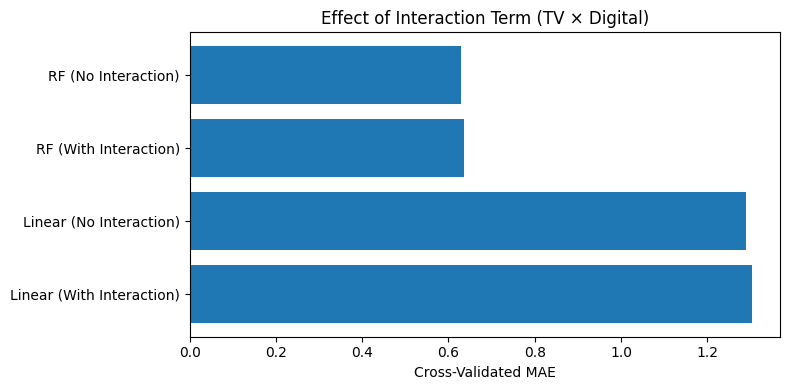

In [15]:
plt.figure(figsize=(8, 4))
plt.barh(
    interaction_comparison["Model"],
    interaction_comparison["CV_MAE"]
)
plt.xlabel("Cross-Validated MAE")
plt.title("Effect of Interaction Term (TV × Digital)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Cross-Channel Synergy: Interaction vs No Interaction (H3)

To directly test the cross-channel synergy hypothesis (H3), models were estimated
with and without the interaction term between TV and Digital_Spend.

By keeping the learning algorithm constant and changing only the feature set,
this comparison isolates the contribution of the interaction effect.

Cross-validation results indicate whether including the interaction term improves
predictive performance (lower MAE / higher R²). An improvement supports the hypothesis
that traditional and digital channels reinforce each other rather than operating independently.


## Predicted vs Actual Sales

This visualization compares predicted sales values with actual sales values
for the best-performing model.

- Each point represents a test observation.
- The diagonal line represents perfect predictions.

The plot helps identify systematic bias, variance, and regions where
the model performs particularly well or poorly.


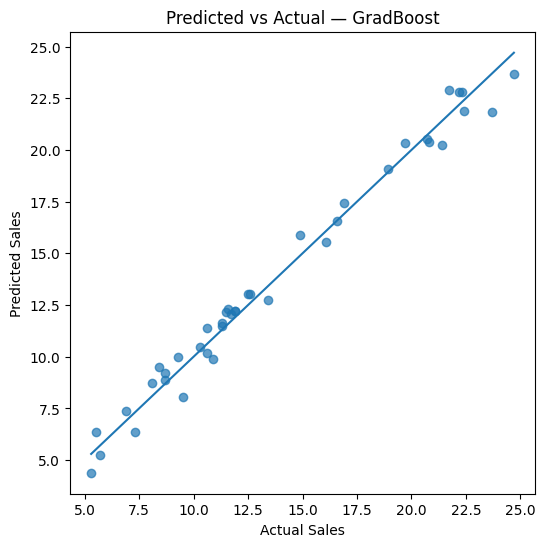

In [16]:
best_name = results.iloc[0]["Model"]
best_pred = preds[best_name]

plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_pred, alpha=0.7)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title(f"Predicted vs Actual — {best_name}")
plt.show()


## Linear Regression Coefficients

Linear regression coefficients represent the marginal effect of each feature on Sales,
holding other variables constant.

Because features are standardized, coefficients are directly comparable.
This allows interpretation of:
- Relative importance of marketing channels
- Direction of influence (positive or negative)

Coefficient analysis supports theory-driven insights into media effectiveness.

In [17]:
coef = lin.named_steps["model"].coef_
coef_df = pd.DataFrame({"Feature": features, "Coefficient": coef}).sort_values("Coefficient", ascending=False)
coef_df


,Feature,Coefficient
0,TV Ad Budget ($),3.507906
1,Radio Ad Budget ($),2.759279
8,TV_x_Digital,0.307700
5,Conversions,0.299303
6,ROI,0.176031
4,CTR,0.165586
2,Newspaper Ad Budget ($),0.075159
7,Engagement_Score,-0.017717
3,Digital_Spend,-0.268291


## Random Forest Feature Importance

Random Forest feature importance measures how much each variable contributes
to reducing prediction error across all decision trees.

Unlike linear coefficients, these importance scores capture:
- Nonlinear relationships
- Interaction effects
- Complex decision boundaries

Comparing feature importance with linear coefficients strengthens confidence
in consistently influential marketing channels.



In [18]:
rf_model = rf.named_steps["model"]
fi = pd.DataFrame({"Feature": features, "Importance": rf_model.feature_importances_}).sort_values("Importance", ascending=False)
fi


,Feature,Importance
0,TV Ad Budget ($),0.610140
1,Radio Ad Budget ($),0.353891
8,TV_x_Digital,0.015628
2,Newspaper Ad Budget ($),0.005894
5,Conversions,0.004049
6,ROI,0.003340
4,CTR,0.002773
3,Digital_Spend,0.002756
7,Engagement_Score,0.001528


In [19]:

libraries = """numpy
pandas
matplotlib
scikit-learn
"""

with open("requirements.txt", "w") as f:
    f.write(libraries)

print("requirements.txt")

requirements.txt
